# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go

import datetime
from time import time
%matplotlib inline
import re

#import pyspark libraries
import pyspark
from pyspark import SparkConf

# import sql Spark libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StringType, IntegerType,DataType
from pyspark.sql.functions import udf
from pyspark.sql.functions import date_format
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, min, max, regexp_replace, concat, count, desc, asc, explode, lit, split, stddev, udf, lower, isnan, when, rank, from_unixtime

# import ml Spark libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# import sklearn ml metrics libraries for metrics calculation
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("My Sparkify app") \
    .getOrCreate()

In [3]:
# get the Spark context
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '38115'),
 ('spark.app.id', 'local-1617139540693'),
 ('spark.driver.host', '5488a941163e'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'My Sparkify app')]

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# import mini-dataset file
file = "./mini_sparkify_event_data.json"
df = spark.read.json(file)

In [6]:
# Let's check the dataset
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

Now, let's prepare some functions that we will use later

In [7]:
# Let's build a function to count the nulls/missing/empty values
def count_null_col(df,column):
    '''
    Function that counts the nulls or missing values that exist in a column
    Input:  
            df: dataset where we want to count null/missing/empty values
            column: column of the dataset we want to count null/missing/empty values
    Output: 
            n_missing: it returns the number of missing values
    '''
    missing = df.filter(((df[column].isNull()) | isnan(df[column])) | (df[column] == ""))
    n_missing = missing.count()
    
    return n_missing

In [8]:
# Let's build a function to count the nulls/missing/empty values of every column of the dataset
def count_null_df(df):
    '''
    Function that counts the nulls or missing values that exist in a dataset
    Input:  
            df: dataset where we want to count null/missing/empty values
    Output: 
            missing: it returns a dictionary with the number of missing values of every column
            in case the column has nulls/missing/empty values
    '''   
    missing = {}
    for col in df.columns:
        n_missing = count_null_col(df,col)
        if n_missing > 0:
            missing.update({col: n_missing})
    
    return missing      

In [9]:
# Let's build a function to count if the categorical and numerical columns of the dataset
def cat_or_num(df):
    '''
    Function that clasifies the kind of columns (categorical or numerical) that exist in a dataset
    Input:  
            df: dataset where we want to clasify columns
    Output: 
            num_cols,cat:cols: it returns a dictionary with the category of every column
    
    '''   
    cat_cols = []
    num_cols = []

    for coltype in df.schema:
        ctype = str(coltype.dataType)
        if ctype == "StringType":
            cat_cols.append(coltype.name)

        elif ctype == "LongType" or ctype == "DoubleType":
            num_cols.append(coltype.name)
            
    return cat_cols, num_cols

In [10]:
# get information about the cols and features
def show_cols_info(df):
    '''
    Function that shows the summary of the information of the columns of the datasets
    Input:  
            df: dataset we want to show information 
    Output: 
            none: it prints a summary and the main values of every column
    
    '''     

    for column in df.columns:
        # show a summary of the important information of the column
        df.describe([column]).show()
        # show the different values of the field
        df.select([column]).distinct().show()
    

In [11]:
# Let's see how many missing values there are in the dataset
missing = count_null_df(df)
print("These are the columns with nulls/missing/empty values: {}\n".format(missing))

These are the columns with nulls/missing/empty values: {'artist': 58392, 'firstName': 8346, 'gender': 8346, 'lastName': 8346, 'length': 58392, 'location': 8346, 'registration': 8346, 'song': 58392, 'userAgent': 8346, 'userId': 8346}



# Drop Rows with Missing Values
As you'll see, it turns out there are no missing values in session column, but there are values that are empty string. Also there are userID values that are empty strings. Let's detect and delete them as these rows are not useful

In [12]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [13]:
df_valid.count()

286500

In [14]:
# Let's get the unique records of UserId
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [15]:
# After viewing the previous query, we can see there are some users with empty UserId
# Let's eliminate them

In [16]:
df_valid = df_valid.filter(df_valid["userId"] != "")

#### Let's count the number of records after remove the empty strings from userId field


In [17]:
df_valid.count()

278154

In [18]:
# And check again if there are no empty field in userId column
df_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

For this usecase, I am going to define Churn as the Cancellation Confirmation event appears
And now, let's start with the EDA phase:

In [19]:
# Let's take an overview of the mini dataset file -->  18 fields 
df_valid.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [20]:
# Let's take a overview of the schema of the dataset file
df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Explanations of the fields:
 
 |-- artist: singer of the song
 |-- auth: method of accessing sparkify          (values: Logged In/Cancelled)
 |-- firstName: first name of the client
 |-- gender: gender of the client                (values: M/F)
 |-- itemInSession: item count in a session
 |-- lastName: last name of the client
 |-- length: lenght of the song
 |-- level: account contract type                (values: free/paid)
 |-- location: main location of the client
 |-- method: method for accessing sparkify (put, get, etc..)   (values: PUT/GET)
 |-- page: page the user visits
 |-- registration: time of the registration (unix timestamp)
 |-- sessionId: identification of the session
 |-- song: song the client has listened
 |-- status: status of the accessing method (http status) (values: 307/404/200)
 |-- ts: information about the time of the user event (unix timestamp)
 |-- userAgent: browser the user has accessed to sparkify with
 |-- userId: identification for the client

In [21]:
# Let's categorize the columns, depending on their type (categorical or numerical)
cat_cols,num_cols = cat_or_num(df)

In [22]:
print ("The categorical columns are: {}".format(cat_cols))

The categorical columns are: ['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']


In [23]:
print ("The numerical columns are: {}".format(num_cols))

The numerical columns are: ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']


In [24]:
# Let's see how many registries the file has --> we have 278.154 records
df_valid.count()

278154

In [25]:
# Let's take a look at the first lines of the file, to see what they look like
df_valid.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [26]:
# Let's see just one row
df_valid.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [27]:
df_valid.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [28]:
# Let's have an statistic overview of the dataset --> but with this view it is difficult to see...
df_valid.describe().show(n=2)

+-------+-----------------+------+---------+------+------------------+--------+-----------------+------+--------+------+------+--------------------+------------------+--------+------------------+--------------------+---------+-----------------+
|summary|           artist|  auth|firstName|gender|     itemInSession|lastName|           length| level|location|method|  page|        registration|         sessionId|    song|            status|                  ts|userAgent|           userId|
+-------+-----------------+------+---------+------+------------------+--------+-----------------+------+--------+------+------+--------------------+------------------+--------+------------------+--------------------+---------+-----------------+
|  count|           228108|278154|   278154|278154|            278154|  278154|           228108|278154|  278154|278154|278154|              278154|            278154|  228108|            278154|              278154|   278154|           278154|
|   mean|551.0852017

In [29]:
# Let's better go field by field 
df_valid.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [30]:
df_valid.describe('auth').show()

+-------+---------+
|summary|     auth|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min|Cancelled|
|    max|Logged In|
+-------+---------+



In [31]:
# We have two values for auth = Logged In or Cancelled
df_valid.select('auth').distinct().collect()

[Row(auth='Cancelled'), Row(auth='Logged In')]

In [32]:
df_valid.describe('firstName').show()

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+



In [33]:
df_valid.describe('gender').show()

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+



In [34]:
df_valid.select('gender').distinct().collect()

[Row(gender='F'), Row(gender='M')]

In [35]:
df_valid.describe('itemInSession').show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [36]:
df_valid.describe('lastName').show()

+-------+--------+
|summary|lastName|
+-------+--------+
|  count|  278154|
|   mean|    null|
| stddev|    null|
|    min|   Adams|
|    max|  Wright|
+-------+--------+



In [37]:
df_valid.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [38]:
df_valid.describe('level').show()

+-------+------+
|summary| level|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|  free|
|    max|  paid|
+-------+------+



In [39]:
df_valid.select('level').distinct().collect() #--> two values: free or paid 

[Row(level='free'), Row(level='paid')]

In [40]:
df_valid.describe('location').show()

+-------+-----------------+
|summary|         location|
+-------+-----------------+
|  count|           278154|
|   mean|             null|
| stddev|             null|
|    min|       Albany, OR|
|    max|Winston-Salem, NC|
+-------+-----------------+



In [41]:
# Let's see the different locations, it is a string composed by two parts separated by a comma: 
# the first one is the name of the location, the second one after the comma is the abbreviation of the location
# for an easier management of this information, we will use the second part

df_valid.select('location').distinct().collect()

[Row(location='Gainesville, FL'),
 Row(location='Atlantic City-Hammonton, NJ'),
 Row(location='Deltona-Daytona Beach-Ormond Beach, FL'),
 Row(location='San Diego-Carlsbad, CA'),
 Row(location='Cleveland-Elyria, OH'),
 Row(location='Kingsport-Bristol-Bristol, TN-VA'),
 Row(location='New Haven-Milford, CT'),
 Row(location='Birmingham-Hoover, AL'),
 Row(location='Corpus Christi, TX'),
 Row(location='Dubuque, IA'),
 Row(location='Las Vegas-Henderson-Paradise, NV'),
 Row(location='Indianapolis-Carmel-Anderson, IN'),
 Row(location='Seattle-Tacoma-Bellevue, WA'),
 Row(location='Albany, OR'),
 Row(location='Winston-Salem, NC'),
 Row(location='Bakersfield, CA'),
 Row(location='Los Angeles-Long Beach-Anaheim, CA'),
 Row(location='Minneapolis-St. Paul-Bloomington, MN-WI'),
 Row(location='San Francisco-Oakland-Hayward, CA'),
 Row(location='Phoenix-Mesa-Scottsdale, AZ'),
 Row(location='Allentown-Bethlehem-Easton, PA-NJ'),
 Row(location='Miami-Fort Lauderdale-West Palm Beach, FL'),
 Row(location='Se

In [42]:
# Prepare the data for a better visualization of the location column
# The location column has the form: Name,Short_Name, eg: 'Lexington-Fayette, KY'
# so we'll get the column location and split it by comma and then get the second part
# and then we'll take only the first part
df_valid = df_valid.withColumn("state", split(col("location"),',').getItem(1))
#df_valid = df_valid.withColumn("state", split(col("state"),'-').getItem(1))
df_valid.select("state").collect()

[Row(state=' CA'),
 Row(state=' MA-NH'),
 Row(state=' CA'),
 Row(state=' MA-NH'),
 Row(state=' CA'),
 Row(state=' MA-NH'),
 Row(state=' MA-NH'),
 Row(state=' CA'),
 Row(state=' CA'),
 Row(state=' CA'),
 Row(state=' MA-NH'),
 Row(state=' MA-NH'),
 Row(state=' CA'),
 Row(state=' MA-NH'),
 Row(state=' MA-NH'),
 Row(state=' CA'),
 Row(state=' MA-NH'),
 Row(state=' FL'),
 Row(state=' CA'),
 Row(state=' MA-NH'),
 Row(state=' FL'),
 Row(state=' CA'),
 Row(state=' WA'),
 Row(state=' MA-NH'),
 Row(state=' FL'),
 Row(state=' CA'),
 Row(state=' WA'),
 Row(state=' MA-NH'),
 Row(state=' FL'),
 Row(state=' CA'),
 Row(state=' WA'),
 Row(state=' MA-NH'),
 Row(state=' CA'),
 Row(state=' FL'),
 Row(state=' WA'),
 Row(state=' WA'),
 Row(state=' CA'),
 Row(state=' MA-NH'),
 Row(state=' CA'),
 Row(state=' WA'),
 Row(state=' FL'),
 Row(state=' MA-NH'),
 Row(state=' FL'),
 Row(state=' WA'),
 Row(state=' WA'),
 Row(state=' CA'),
 Row(state=' MA-NH'),
 Row(state=' MA-NH'),
 Row(state=' FL'),
 Row(state=' CA'),

In [43]:
df_valid.describe('method').show()

+-------+------+
|summary|method|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|   GET|
|    max|   PUT|
+-------+------+



In [44]:
df_valid.select('method').distinct().collect() # there are two methods: PUT/GET

[Row(method='PUT'), Row(method='GET')]

In [45]:
df_valid.describe('page').show()

+-------+-------+
|summary|   page|
+-------+-------+
|  count| 278154|
|   mean|   null|
| stddev|   null|
|    min|  About|
|    max|Upgrade|
+-------+-------+



In [46]:
df_valid.select('page').distinct().collect() # there are 19 different pages

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [47]:
df_valid.describe('registration').show()

+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|              278154|
|   mean|1.535358834084427...|
| stddev| 3.291321616327586E9|
|    min|       1521380675000|
|    max|       1543247354000|
+-------+--------------------+



In [48]:
df_valid.describe('sessionId').show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [49]:
df_valid.describe('song').show()

+-------+--------------------+
|summary|                song|
+-------+--------------------+
|  count|              228108|
|   mean|            Infinity|
| stddev|                 NaN|
|    min|ÃÂg ÃÂtti Gr...|
|    max|ÃÂau hafa slopp...|
+-------+--------------------+



In [50]:
df_valid.describe('status').show()

+-------+------------------+
|summary|            status|
+-------+------------------+
|  count|            278154|
|   mean|209.10321620397335|
| stddev|30.151388851328214|
|    min|               200|
|    max|               404|
+-------+------------------+



In [51]:
df_valid.select('status').distinct().collect() # there are 3 possible status

[Row(status=307), Row(status=404), Row(status=200)]

In [52]:
df_valid.describe('ts').show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              278154|
|   mean|1.540958915431871...|
| stddev|1.5068287123306298E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [53]:
df_valid.describe('userAgent').show()

+-------+--------------------+
|summary|           userAgent|
+-------+--------------------+
|  count|              278154|
|   mean|                null|
| stddev|                null|
|    min|"Mozilla/5.0 (Mac...|
|    max|Mozilla/5.0 (comp...|
+-------+--------------------+



In [54]:
df_valid.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           278154|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|               10|
|    max|               99|
+-------+-----------------+



In [55]:
df_valid.select("userID").show()

+------+
|userID|
+------+
|    30|
|     9|
|    30|
|     9|
|    30|
|     9|
|     9|
|    30|
|    30|
|    30|
|     9|
|     9|
|    30|
|     9|
|     9|
|    30|
|     9|
|    74|
|    30|
|     9|
+------+
only showing top 20 rows



In [56]:
# Let's see how many distinct users are in this dataset --> 225
df_valid.select("userId").distinct().count()

225

In [57]:
# And let's see how many different pages are --> 19
df_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [58]:
# Let's see an example of row in the dataset, for instance let's see userid= 30
df_valid.select(["UserId", "firstname", "page", "song"]).where(df_valid.userId=="30").collect()[0]

Row(UserId='30', firstname='Colin', page='NextSong', song='Rockpools')

In [59]:
# Now we are going to add two new columns derived from ts field:
# We would like to know the hour and datetime in UTF timestamp
# for that we prepare a lambda function
get_date       = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
get_month      = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
get_day        = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)
get_hour       = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
get_weekday    = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [60]:
# we apply the lambda function to convert the ts into hour and data
# we apply also the lambda function to convert the registration field into a new field "registration_time" with the timestamp 
df_valid = df_valid.withColumn("registration_time", get_date(df_valid.registration))
df_valid = df_valid.withColumn("date", get_date(df_valid.ts))
df_valid = df_valid.withColumn("month", get_month(df_valid.ts))
df_valid = df_valid.withColumn("day_of_month", get_day(df_valid.ts))
df_valid = df_valid.withColumn("hour", get_hour(df_valid.ts))
df_valid = df_valid.withColumn('day_of_week', get_weekday(df_valid.ts))

In [61]:
# Let's prepare sparksql 
# To do that, we need to create a temporary table, where we'll perform the SQL queries
df_valid.createOrReplaceTempView("Sparkify_sql")

In [62]:
# Let's prepare the registration_time for human understanding, that is year-month-day hour:minute:second, 
# And also let's add the weekday
df_time = df_valid.select('registration_time', date_format('registration_time', 'u').alias('weekday'))
df_time.show()

+-------------------+-------+
|  registration_time|weekday|
+-------------------+-------+
|2018-09-28 22:22:42|      5|
|2018-09-30 18:20:30|      7|
|2018-09-28 22:22:42|      5|
|2018-09-30 18:20:30|      7|
|2018-09-28 22:22:42|      5|
|2018-09-30 18:20:30|      7|
|2018-09-30 18:20:30|      7|
|2018-09-28 22:22:42|      5|
|2018-09-28 22:22:42|      5|
|2018-09-28 22:22:42|      5|
|2018-09-30 18:20:30|      7|
|2018-09-30 18:20:30|      7|
|2018-09-28 22:22:42|      5|
|2018-09-30 18:20:30|      7|
|2018-09-30 18:20:30|      7|
|2018-09-28 22:22:42|      5|
|2018-09-30 18:20:30|      7|
|2018-09-19 13:53:39|      3|
|2018-09-28 22:22:42|      5|
|2018-09-30 18:20:30|      7|
+-------------------+-------+
only showing top 20 rows



In [63]:
# Now let's calculate how long the user is subscribed to our Sparkify service
# To calculate that, we have to substract current date to the registration date

def get_days_from_registration(df_valid):
    days_from_registration = df_valid.ts - df_valid.registration
    days_from_registration = days_from_registration/(1000*3600*24)
    
    return days_from_registration
    
    
df_valid = df_valid.withColumn("subscription_days", get_days_from_registration(df_valid))

In [64]:
df_valid.select('subscription_days').sort("subscription_days").collect()[-1]

Row(subscription_days=256.3776736111111)

In [65]:
df_valid.select('userID', 'subscription_days').take(3)

[Row(userID='30', subscription_days=2.068923611111111),
 Row(userID='9', subscription_days=0.2378472222222222),
 Row(userID='30', subscription_days=2.0721296296296297)]

### Now we continue with our Data Exploration! Let's do it just making questions!


In [66]:
#### Question: How many days/months does our dataset contain?

In [67]:
# We have a dataset with an initial date = 2018-10-01
day_from = list(df_valid.select('date').sort("date").collect()[0])
day_from 

['2018-10-01 00:01:57']

In [68]:
# We have a dataset with an end date = 2018-12-03
day_to = list(df_valid.select('date').sort("date").collect()[-1])
day_to

['2018-12-03 01:11:16']

In [69]:
#### We have a dataset with an initial date = 2018-10-01 and an end date = 2018-12-03
#### So we have a dataset of aprox 2 months information 

In [70]:
# Let's see the states
df_valid.select('userId','state').distinct().groupby('state').count().show()

+------------+-----+
|       state|count|
+------------+-----+
|       NE-IA|    1|
|       PA-NJ|    1|
|          WA|    4|
| DC-VA-MD-WV|    4|
|          AL|    4|
|          MI|    5|
|       MN-WI|    3|
|    IL-IN-WI|    6|
|       MD-WV|    1|
|          NH|    2|
|          AK|    2|
|          AR|    1|
|          AZ|    7|
|       MA-NH|    5|
|          WV|    1|
|    TN-MS-AR|    1|
|       MO-IL|    6|
|          TN|    1|
|          NY|    5|
|          MD|    2|
+------------+-----+
only showing top 20 rows



#### Question: How is the proportion between Males and Females in our musical streaming service ? 


In [71]:
ngender = df_valid.select('gender','userId').distinct().groupby('gender').count().toPandas()
ngender.head(5)

,gender,count
0,F,104
1,M,121


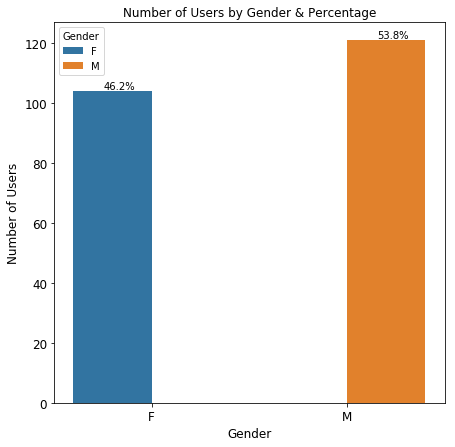

In [72]:
# Let's plot this proportion with a graphic
# and show the percentage above
plt.figure(figsize = (7,7))
plt.title('Number of Users by Gender & Percentage')
ax = sns.barplot(x='gender', y='count',hue='gender', data=ngender);

# this code is to calculate the percentage 
# and present the numbers above the bars and centered in the middle
total = ngender.iloc[0]['count'] + ngender.iloc[1]['count']
for p in ax.patches:
    if p.get_height()>0:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2.6
        y = p.get_y() + p.get_height() + 0.7
        ax.annotate(percentage, (x, y))

plt.xticks(size=12)
plt.xlabel('Gender',size=12)
plt.yticks(size=12)
plt.ylabel('Number of Users', size=12)
plt.legend(title='Gender', loc='best');
plt.savefig('Users_by_Gender.png')

#### Our datasets contains 104 records corresponding to female clients (46.2%) and 121 (53.8%) corresponding to male clients


#### Question: What about the level of the users? Is there a difference between male and female subscriptors?


In [73]:
# Now let's check the users by level of account and gender
# As we are going to use some sns plots, we have to convert the datasets to Pandas
df_gender_level = df_valid.select('userId','gender','level').distinct().groupby('gender','level').count().toPandas().sort_values(by='count')
df_gender_level.head()

,gender,level,count
2,F,paid,79
3,M,paid,86
1,F,free,89
0,M,free,106


#### For both free and paid services, the number of men is sligthly higher


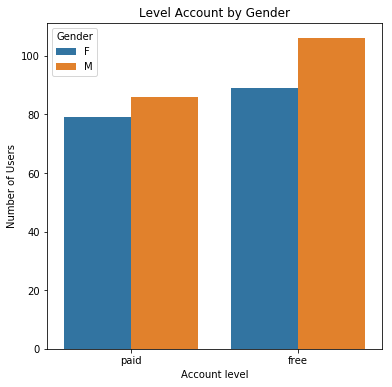

In [74]:
plt.figure(figsize = (6,6))
ax = sns.barplot(x='level', y='count',hue='gender', data=df_gender_level);

plt.title('Number of Users by Gender & Percentage')

plt.xlabel('Account level')
plt.ylabel('Number of Users')
plt.title('Level Account by Gender')
plt.legend(title='Gender', loc='best');
plt.savefig('Level_Account_by_Gender.png')

This graphic shows that there are more users with a paid account. 
And most users are women.

#### Question: What about the location of the users? Does this feature affects on the level of service?

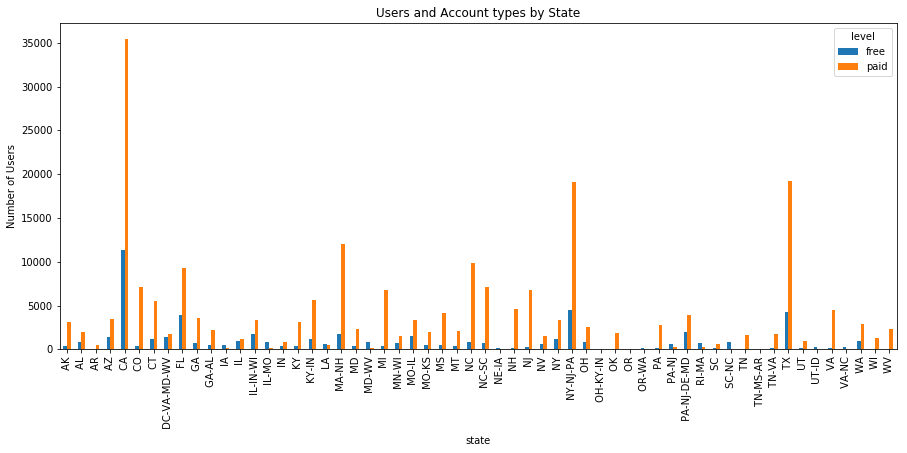

In [75]:
df_location_level = df_valid.select('userId','state','level').groupby('state','level').count().orderBy(desc('count')).toPandas()
fig = plt.figure(figsize=(15,6))
plt.ylabel('Number of Users')
ax = fig.gca()
df_location_level.pivot(index='state', columns='level', values='count').plot(kind='bar', ax=ax)
plt.title('Users and Account types by State')
plt.savefig('df_state_level.png')

The previous graphic shows there are more users (also with paid accounts) in California (CA), New York (NY) and Texas (TX)

#### Question: What about the UserAgent? Is there a difference between subscriptors?

In [76]:
# Now let's see the different browsers the users login, that indicates different Operating Systems from users
df_os = df_valid.select('userAgent','userId').distinct().groupby('userAgent').count().toPandas().sort_values(by='count')
df_os

,userAgent,count
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5...",1
26,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",1
25,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...",1
24,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,1
30,Mozilla/5.0 (X11; Linux x86_64; rv:31.0) Gecko...,1
22,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",1
20,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",1
18,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",1
17,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5...",1
16,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,1


In [77]:
df_userAgent_level = df_valid.select('userId','userAgent','level').groupby('userAgent','level').count().toPandas().sort_values(by='count')
df_userAgent_level.head()

,userAgent,level,count
75,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",free,5
87,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...,free,25
65,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; r...,free,35
94,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...,paid,37
100,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...,free,62


In [78]:
# Maybe it's interesting augment our dataset with the device the users utilize our Sparkify service
# let's map the operating system, through the Browser

map = {'macintosh':'MAC', 'iphone':'IPHONE','ipad':'IPAD',
       'x11':'LINUX','compatible':'WINDOWS',
       'windows nt 5.0':'WINDOWS','windows nt 5.1':'WINDOWS',
       'windows nt 6.1':'WINDOWS', 'windows nt 6.0':'WINDOWS',
       'windows nt 6.2':'WINDOWS','windows nt 6.3':'WINDOWS'}

classify_os = udf(lambda x: map[re.findall('\(([^\)]*)\)', x)[0].split(';')[0].lower()])

df_valid = df_valid.withColumn('OS', classify_os(df_valid.userAgent))

In [79]:
# And now we would like to know the count of OS's connections depending on the subscription level of the users
df_os_level = df_valid.select('userId','OS','level').groupby('OS','level').count().orderBy(desc('count')).toPandas()
df_os_level.head(15)

,OS,level,count
0,WINDOWS,paid,115495
1,MAC,paid,82713
2,WINDOWS,free,28376
3,MAC,free,20036
4,IPAD,paid,9701
5,IPHONE,paid,7268
6,LINUX,paid,7256
7,IPHONE,free,3924
8,LINUX,free,1705
9,IPAD,free,1680


In [80]:
# But for unique userid's, what is the favourite OS?
df_os_level = df_valid.select('userId','OS','level').distinct().groupby('OS','level').count().orderBy(desc('count')).toPandas()
df_os_level.head(15)

,OS,level,count
0,WINDOWS,free,98
1,WINDOWS,paid,84
2,MAC,free,74
3,MAC,paid,60
4,IPHONE,free,12
5,LINUX,paid,10
6,LINUX,free,8
7,IPHONE,paid,8
8,IPAD,free,3
9,IPAD,paid,3


#### In the previous table, we can see that Windows is the favourite Operating Systems for both free and paid subscription
#### And on the below table we can confirm by number of distinct users (remember there are 225 users during the time range of this analysis)

In [81]:
df_os_test = df_valid.select('userId','OS').distinct().groupby('OS').count().orderBy(desc('count')).toPandas()
df_os_test.head(15)

,OS,count
0,WINDOWS,111
1,MAC,86
2,IPHONE,13
3,LINUX,12
4,IPAD,3


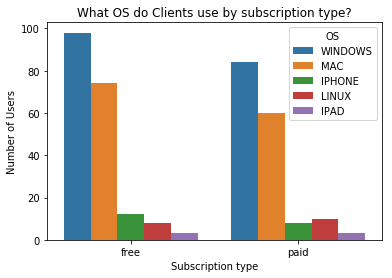

In [82]:
# level subscription of the user by Operating System
level_os = df_valid.dropDuplicates(['userId','OS','level']).groupby(['OS', 'level']).count().orderBy(desc('count')).toPandas()

ax = sns.barplot(x='level', y='count',hue='OS', data=level_os);
plt.xlabel('Subscription type')
plt.ylabel('Number of Users')
plt.title('What OS do Clients use by subscription type?')
plt.legend(title='OS', loc='best');
plt.savefig('df_OS_by_subscription_type.png')

#### The above table shows graphically the OS the users connect to our Sparkify service, both for free and paid subscription

#### Now let's see the number of songs a users listens to during the day (24 hours)

In [83]:
songs_in_hour = df_valid.filter(df_valid.page == "NextSong").groupby(df_valid.hour).count().orderBy(df_valid.hour.cast("float"))

In [84]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [85]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

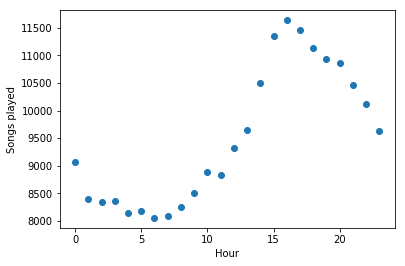

In [86]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlabel("Hour")
plt.ylabel("Songs played");

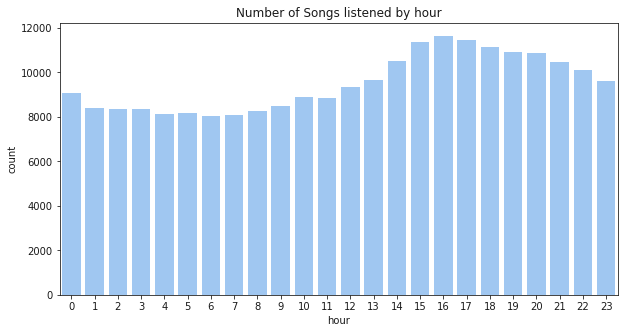

In [87]:
sns.set_color_codes("pastel")
plt.figure(figsize=(10,5))
sns.barplot(x='hour', y='count', data=songs_in_hour_pd, color="b")
plt.title('Number of Songs listened by hour')
plt.ylabel('count');
plt.savefig('df_number_songs_by_hour.png')

In [88]:
# Now let's see if there are days when people listen more songs
songs_in_days = df_valid.filter(df_valid.page == "NextSong").groupby(df_valid.day_of_month).count().orderBy(df_valid.day_of_month.cast("float"))

In [89]:
# Let's calculate how many songs people listen per month
songs_in_days_pd = songs_in_days.toPandas()
songs_in_days_pd.day_of_month = pd.to_numeric(songs_in_days_pd.day_of_month)

In [90]:
songs_in_days_pd

,day_of_month,count
0,1,9187
1,2,9646
2,3,6411
3,4,5729
4,5,6866
5,6,6796
6,7,5917
7,8,7390
8,9,9217
9,10,7791


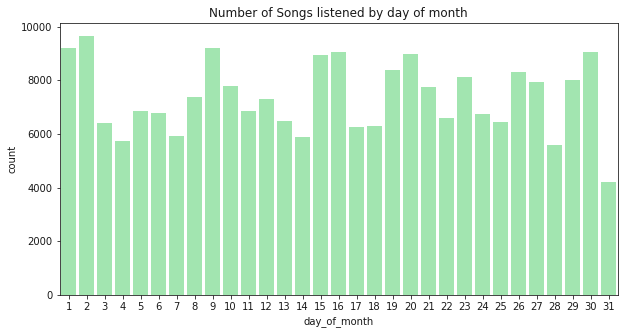

In [91]:
# And show these numbers with a nice plot
sns.set_color_codes("pastel")
plt.figure(figsize=(10,5))
sns.barplot(x='day_of_month', y='count', data=songs_in_days_pd, color="g")
plt.title('Number of Songs listened by day of month')
plt.ylabel('count');
plt.savefig('df_number_songs_by_day_of_month.png')

In [92]:
#### Question: Is there a day of week when users listen more songs?

In [93]:
# Let's prepare the query
songs_in_weekdays = df_valid.filter(df_valid.page == "NextSong").groupby(df_valid.day_of_week).count().orderBy(df_valid.day_of_week)

In [94]:
# and convert it to pandas to display 
songs_in_weekdays_pd = songs_in_weekdays.toPandas()
songs_in_weekdays.day_of_week = pd.to_numeric(songs_in_weekdays_pd.day_of_week)

In [95]:
songs_in_weekdays.show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|          0|17370|
|          1|35373|
|          2|38830|
|          3|37675|
|          4|36300|
|          5|39514|
|          6|23046|
+-----------+-----+



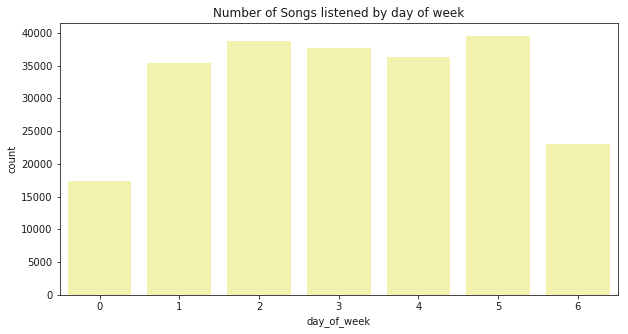

In [96]:
# And plot with a barplot
sns.set_color_codes("pastel")
plt.figure(figsize=(10,5))
sns.barplot(x='day_of_week', y='count', data=songs_in_weekdays_pd, color="y")
plt.title('Number of Songs listened by day of week')
plt.ylabel('count');
plt.savefig('df_number_songs_by_day_of_week.png')

##### It seems that users prefer weekdays to use the service


In [97]:
#### With the graphic above, we cannot see a behavioural pattern 


# Users Downgrade Their Accounts

To find when users downgrade their accounts, let's use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events and then flag those log entries

### Now let's calculate the users who downgrade the service, that is, the users that downgraded or cancellate the service

In [98]:
downgrade_select = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

In [99]:
df_valid = df_valid.withColumn('downgrade_select', downgrade_select('page'))

In [100]:
df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- state: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- date: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_month: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- subscription_days: 

###### With the previous commands, we get only the time when the user downgraded, 
###### but we would like to have the information of that user from the beginning

In [101]:
# We need to have all information from users that have downgraded Sparkify service
# so we need to save an interval of time
windowSpec  = Window.partitionBy('userId')

df_valid = df_valid.withColumn('will_downgrade', max('downgrade_select').over(windowSpec))

In [102]:
df_downgrade = df_valid.select('userId','gender','downgrade_select').distinct().groupby('gender','downgrade_select').count().toPandas().sort_values(by='count')
df_downgrade.head()

,gender,downgrade_select,count
0,M,1,21
2,F,1,28
1,F,0,104
3,M,0,121


#### Women are slightly more likely to downgrade than men

In [103]:
df_downgrade_level = df_valid.select('userId','level','downgrade_select').distinct().groupby('level','downgrade_select').count().toPandas().sort_values(by='count')
df_downgrade_level.head()

,level,downgrade_select,count
2,paid,1,49
0,paid,0,165
1,free,0,195


# Now let's calculate the users who churn, that is, the users that confirmed cancellation

In [104]:
churn_confirmation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_valid = df_valid.withColumn("churn", churn_confirmation(df_valid.page))
df_users_churned = df_valid.withColumn("churned", churn_confirmation("page"))

In [105]:
df_valid = df_valid.withColumn('will_churn', max('churn').over(windowSpec))

In [106]:
# Let's remember the schema of the data
df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- state: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- date: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_month: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- subscription_days: 

### Question: How many users churned? And what's the rate of churned users vs the total number of users ? 

In [107]:
# Let's count the number of user cancellations (churns) --> there are 52 users who have cancel the service
users_churned = df_users_churned.filter(df_users_churned["churned"] ==1).count()
# Let's calculate the total number of users
total_users = df_valid.select('userId').distinct().count()
# Let's calculate the percentage
percentage_churn = df_users_churned.groupby("userId").agg({"churned":"sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]

print("Number of users who churned: {} vs Total Users: {}".format(users_churned, total_users))
print("Percentage of users who churned: {:.2f}%".format(percentage_churn * 100))

Number of users who churned: 52 vs Total Users: 225
Percentage of users who churned: 23.11%


##### With those numbers, we can affirm that we have an imbalanced dataset....

In [108]:
# Let's see some details of the users who churned
df_users_churned.select(["userId", "gender", "level", "state", "ts"]).where(df_valid.churn == 1).sort("ts").show(20)

+------+------+-----+------------+-------------+
|userId|gender|level|       state|           ts|
+------+------+-----+------------+-------------+
|100011|     M| free|          OR|1538417085000|
|100001|     F| free|          FL|1538498205000|
|100024|     M| free|    NY-NJ-PA|1538695038000|
|300007|     M| paid|          AZ|1538705338000|
|100006|     F| free|          MI|1538753070000|
|    18|     M| paid|       MO-KS|1538943990000|
|100019|     M| free|          WA|1538953071000|
|    32|     M| paid|          AZ|1539033046000|
|100003|     F| free|          FL|1539274781000|
|   125|     M| free|          TX|1539318918000|
|   105|     M| paid|          IN|1539375441000|
|    17|     F| paid| PA-NJ-DE-MD|1539465584000|
|100023|     M| paid|          SC|1539475237000|
|   143|     F| free|       VA-NC|1539588854000|
|200001|     M| free| DC-VA-MD-WV|1539629720000|
|   101|     M| paid|          CO|1539729037000|
|   129|     M| paid|          MI|1539736161000|
|   121|     M| paid

In [109]:
# Let's drop the UserId duplicates and then count the users who churned
# And prepare the data to be plotted with a sns, so we need to convert to a Pandas Dataframe
total_churn = df_valid.dropDuplicates(['userId','churn']).groupby(['churn']).count().toPandas()
print("Number of users who churned: {} ".format(total_churn))

Number of users who churned:    churn  count
0      1     52
1      0    225 


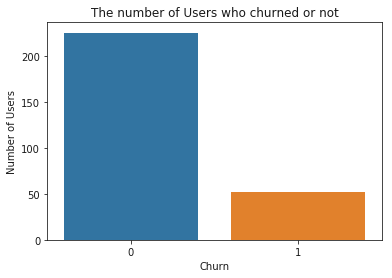

In [110]:
# We like to see it graphically
sns.barplot(x='churn', y='count', data=total_churn);
plt.xlabel('Churn')
plt.ylabel('Number of Users')
plt.title('The number of Users who churned or not')
plt.legend(title='Churn', loc='best');
plt.savefig('Users_who_churned.png')

#### Question: Is there a difference in the gender between the users who churned and who did not churn? 


In [111]:
# Let's see the churn flag and also the gender
df_churn_gender = df_valid.select('userId','gender','churn').distinct().groupby('gender','churn').count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M|    1|   32|
|     F|    0|  104|
|     F|    1|   20|
|     M|    0|  121|
+------+-----+-----+



In [112]:
# Let's prepare a query, convert the sorted data to pandas 
df_churn_gender = df_valid.select('userId','gender','churn').distinct().groupby('gender','churn').count().toPandas().sort_values(by='count')

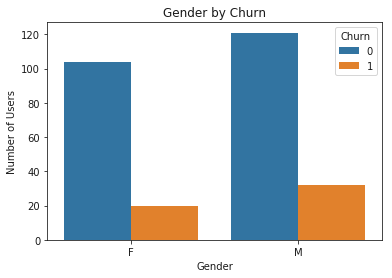

In [113]:
sns.barplot(x='gender', y='count',hue='churn', data=df_churn_gender);
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.title('Gender by Churn')
plt.legend(title='Churn', loc='best');
plt.savefig('Gender by Churn.png')

#### Question: Is there a difference in the subscription type between the users who churned and who did not churn? 


In [114]:
df_churn_level = df_valid.select('userId','level','churn').distinct().groupby('level','churn').count().toPandas().sort_values(by='count')

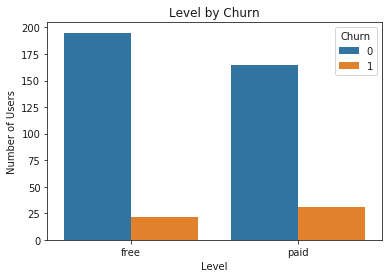

In [115]:
sns.barplot(x='level', y='count',hue='churn', data=df_churn_level);
plt.xlabel('Level')
plt.ylabel('Number of Users')
plt.title('Level by Churn')
plt.legend(title='Churn', loc='best');
plt.savefig('Level by Churn.png')

#### Question: Is there a difference in the location between the users who churned and who did not churn? 


In [116]:
df_churn_location = df_valid.select('userId','state','churn').distinct().groupby('state','churn').count().orderBy(desc('count')).toPandas()

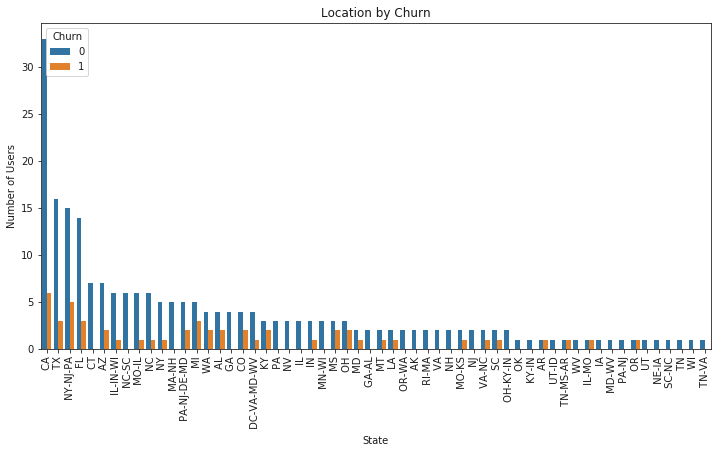

In [117]:
fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x='state', y='count',hue='churn', data=df_churn_location);
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Number of Users')
plt.title('Location by Churn')
plt.legend(title='Churn', loc='best');
plt.savefig('Location by Churn.png')

#### Question: Is there a difference in the day_of_week between the users who churned and who did not churn? 

In [118]:
day_of_week_by_churn = df_valid.dropDuplicates(['userId','day_of_week']).groupby(['day_of_week','churn']).count().toPandas()

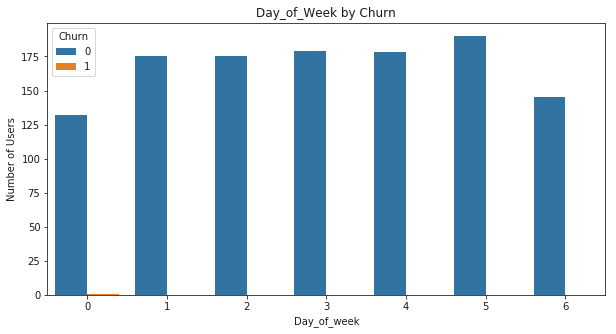

In [119]:
fig, ax = plt.subplots(figsize=(10, 5))
g = sns.barplot(x="day_of_week",y="count", hue="churn", data=day_of_week_by_churn, ax=ax);
plt.xlabel('Day_of_week')
plt.ylabel('Number of Users')
plt.title('Day_of_Week by Churn')
plt.legend(title='Churn', loc='best');
plt.savefig('Day_of_week by Churn.png')

In [120]:
##### The data is very imbalanced, but it seems that the favourite day to churn is Monday (day_of_week = 0)
##### Maybe the responsibles of Sparkify could prepare some campaigns for Mondays (free trials, discounts, offers, etc..)

In [121]:
df_valid.select(['userId','page','churn','downgrade_select']).groupby(['page','downgrade_select']).count().toPandas()

,page,downgrade_select,count
0,Thumbs Up,0,12551
1,Upgrade,0,499
2,Cancel,0,52
3,Logout,0,3226
4,NextSong,0,228108
5,Submit Upgrade,0,159
6,Help,0,1454
7,Save Settings,0,310
8,Home,0,10082
9,Add to Playlist,0,6526


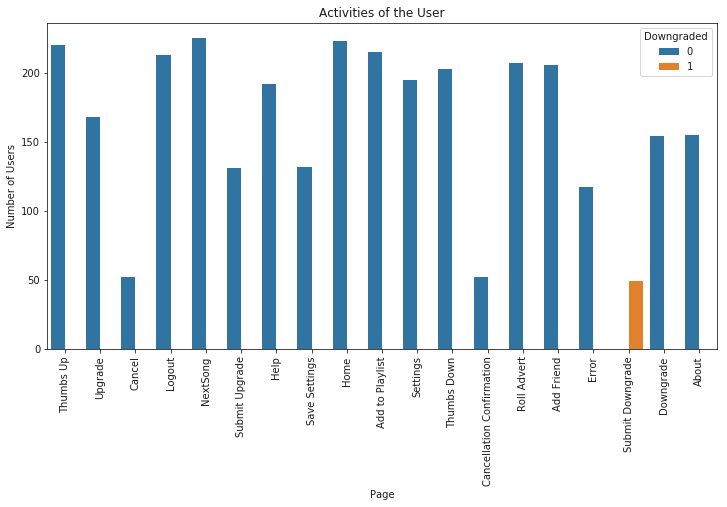

In [127]:
page_total_downgraded = df_valid.dropDuplicates(['userId','page']).groupby(['page','downgrade_select']).count().toPandas()

fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x='page', y='count',hue='downgrade_select', data=page_total_downgraded);
plt.xticks(rotation=90)
plt.xlabel('Page')
plt.ylabel('Number of Users')
plt.title('Activities of the User')
plt.legend(title='Downgraded', loc='best');
plt.savefig('Activities_User_downgraded.png')

In [128]:
#### Question: Is there a difference in the actions between the users who churned and those who did not churn? 
#There are less movements on the users that are going to churn, less Thumbs-Up, less Thumbs-Down, etc..

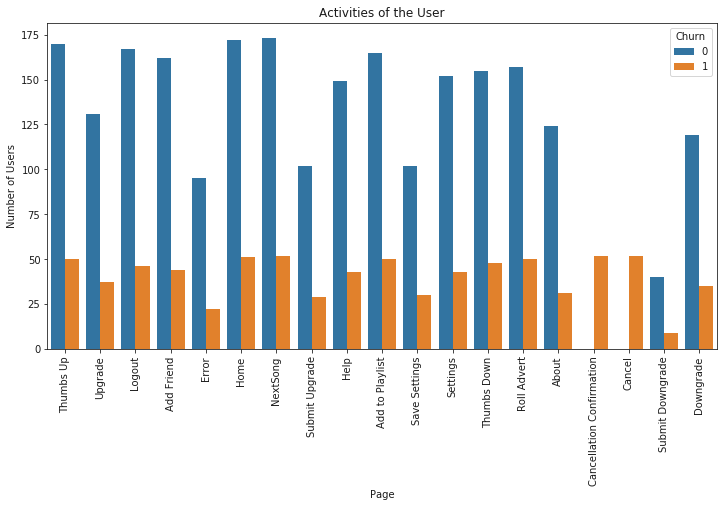

In [129]:
page_total_churn = df_valid.dropDuplicates(['userId','page']).groupby(['page','will_churn']).count().toPandas()

fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x='page', y='count',hue='will_churn', data=page_total_churn);
plt.xticks(rotation=90)
plt.xlabel('Page')
plt.ylabel('Number of Users')
plt.title('Activities of the User')
plt.legend(title='Churn', loc='best');
plt.savefig('Activities_User_Page.png')

In [130]:
# Let's try sparksql 
# To do that, we need to create a temporary table, where we'll perform the SQL queries
df_valid.createOrReplaceTempView("Sparkify_sql")

#### Question: What are the most played songs?

##### Now let's use spark.sql

In [131]:
songs_artists = spark.sql('''
        SELECT song, count(song) AS TOP_SONGS
        FROM Sparkify_sql
        GROUP BY song
        ORDER BY TOP_SONGS DESC
        LIMIT 10
         
''').show()

+--------------------+---------+
|                song|TOP_SONGS|
+--------------------+---------+
|      You're The One|     1153|
|                Undo|     1026|
|             Revelry|      854|
|       Sehr kosmisch|      728|
|Horn Concerto No....|      641|
|Dog Days Are Over...|      574|
|             Secrets|      466|
|        Use Somebody|      459|
|              Canada|      435|
|             Invalid|      424|
+--------------------+---------+



#### Question: What are the artist, users listen the most?

In [132]:
songs_artists = spark.sql('''
        SELECT artist, count(artist) AS TOP_ARTIST
        FROM Sparkify_sql
        GROUP BY artist
        ORDER BY TOP_ARTIST DESC
        LIMIT 10
         
''').show()

+--------------------+----------+
|              artist|TOP_ARTIST|
+--------------------+----------+
|       Kings Of Leon|      1841|
|            Coldplay|      1813|
|Florence + The Ma...|      1236|
|       Dwight Yoakam|      1135|
|            BjÃÂ¶rk|      1133|
|      The Black Keys|      1125|
|                Muse|      1090|
|       Justin Bieber|      1044|
|        Jack Johnson|      1007|
|              Eminem|       953|
+--------------------+----------+



#### Question: What is the average length of song, users listen?


In [133]:
songs_length = spark.sql('''
        SELECT length
        FROM Sparkify_sql
''')

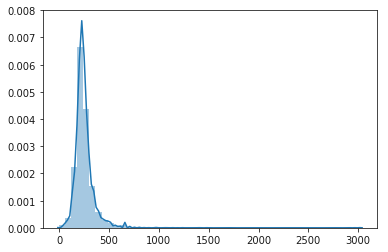

In [134]:
sns.distplot(songs_length.toPandas().dropna());

##### The average duration is about 250 seconds


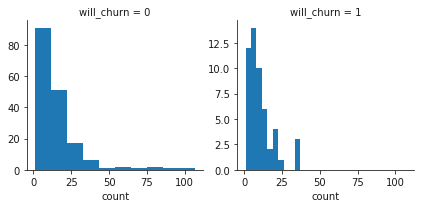

In [135]:
sessionId_total_churn = df_valid.dropDuplicates(['userId','will_churn','sessionId']).groupby(['userId','will_churn']).count().toPandas()

# compare two groups of users
g = sns.FacetGrid(sessionId_total_churn, col="will_churn", sharey=False)
g.map(plt.hist, "count");

##### The users who don't churn use the Sparkify service much more than users who will churn

In [136]:
sessionId_total_churn.head(15)

,userId,will_churn,count
0,100010,0,7
1,200002,0,6
2,125,1,1
3,124,0,29
4,51,1,10
5,7,0,7
6,15,0,15
7,54,1,37
8,155,0,6
9,100014,1,6


In [137]:
# Let's see a record with a user with the time log, page and level
df_valid.select(["userId", "firstname", "ts", "page", "level"]).where(df_valid.userId == "125").sort("ts").collect()[0]

Row(userId='125', firstname='Mason', ts=1539317144000, page='NextSong', level='free')

In [138]:
# Let's see more information about the 52 users who churned
df_valid.select(["userId", "firstname", "ts", "page", "level"]).where(df_valid.churn == 1).sort("ts").collect()[0]

Row(userId='100011', firstname='Sebastian', ts=1538417085000, page='Cancellation Confirmation', level='free')

In [139]:
# Let's calculate the max 
avg_time_user = df_valid.agg({"itemInSession": "max"}).collect()[0]

In [140]:
avg_time_user

Row(max(itemInSession)=1321)

#### Question: Is there a difference in time between the users who churned and who did not churn? 

In [141]:
df_membership = df_valid.select(["userId", "registration", "ts", "churn"]) \
    .withColumn('membership_time',(df_valid.ts-df_valid.registration)) \
    .groupBy('userId', 'churn') \
    .agg({'membership_time':'max'}) \
    .withColumnRenamed('max(membership_time)', 'membership_time') \
    .select('userId', (col('membership_time')/1000/86400).alias('membership_time'),'churn') \
    .sort('membership_time') \
    .toPandas()                       

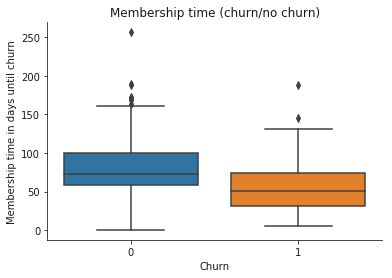

In [142]:
ax = sns.boxplot(data=df_membership, y='membership_time', x='churn', orient='v')
plt.ylabel('Membership time in days until churn')
plt.xlabel('Churn')
plt.title('Membership time (churn/no churn)')
sns.despine(ax=ax);
plt.savefig('Membership_time.png')

##### With the previous boxplot graphic we can see that users who churn
##### stay less time in the Sparkify service than those who don't churn
##### Users who churn stay 50 days in average
##### Users who don't churn stay aprox. 75 days in average 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [143]:
# Let's remember the fields of our datset
# There are some fields that we can transform from categorical to numerical: e.g: gender, level
df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- state: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- date: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_month: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- subscription_days: 

These are the features I will include to build the model
Features:
 |-- userId: string (nullable = true)
 |-- churn: cancellation of the service
 |-- level: type of subscription + I will convert into number 0/1
 |-- n_artists: number of artist a user listens to + I will convert into number
 |-- n_songs:number of songs a user listens to + I will convert into number  
 |-- n_songs_play:number of songs added to the playlist + I will convert into number   
 |-- n_thumbs_up: number of thumbs up + I will convert into number
 |-- n_thumbs_down:  number of thumbs down + I will convert into number 
 |-- n_Errors: long (nullable = true)
 |-- n_friends: number of friends + I will convert into number 
 |-- n_Rolls: number of spots displayed to the user
 |-- n_Help: number of visits to help page
 |-- total_sdays: time of the subscription (in days)
 |-- n_sessions: number of sesions of a user
 |-- IPAD: the user connects with an IPAD to our Sparkify service
 |-- IPHONE: the user connects with an IPHONE to our Sparkify service
 |-- LINUX: the user connects with a Linux device to our Sparkify service
 |-- MAC: the user connects with a MAC device to our Sparkify service
 |-- WINDOWS: the user connects with a WINDOWS to our Sparkify service

#### Features related to the session


#### 1. number of sessions by user

In [145]:
# Let's calculate the number of the sessions of a user
n_sessions = df_valid.select('userId','sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count','n_sessions')
df_n_sessions = n_sessions.withColumn('n_sessions', n_sessions.n_sessions.cast('bigint'))
df_n_sessions.count()

225

In [146]:
df_n_sessions.take(2)

[Row(userId='100010', n_sessions=7), Row(userId='200002', n_sessions=6)]

#### 2. Operating System (device)

In [147]:
# Let's take the OS the user connects to the Sparkify session and make one hot encoding with the pivot option
df_os = df_valid.select('userId','OS').dropDuplicates().groupby('userId').pivot('OS').agg(count('OS')).fillna(0)

In [148]:
df_os.show(2)

+------+----+------+-----+---+-------+
|userId|IPAD|IPHONE|LINUX|MAC|WINDOWS|
+------+----+------+-----+---+-------+
|100010|   0|     1|    0|  0|      0|
|200002|   0|     1|    0|  0|      0|
+------+----+------+-----+---+-------+
only showing top 2 rows



#### Features related to the subscription
#### 1. subscription days of a user
#### 2. subscription cancelled (churn)
#### 3. level of subscription (payment)

In [149]:
# Let's calculate the subscription days a user stays in the service
subscription_days = df_valid.select('userId','subscription_days').groupBy('userId').agg({'subscription_days':'max'}).withColumnRenamed('max(subscription_days)','total_sdays')
df_subscription_days = subscription_days.withColumn('total_sdays', subscription_days.total_sdays.cast('double'))
df_subscription_days.count()

225

In [150]:
df_subscription_days.take(4)

[Row(userId='100010', total_sdays=55.64365740740741),
 Row(userId='200002', total_sdays=70.07462962962963),
 Row(userId='125', total_sdays=71.31688657407408),
 Row(userId='51', total_sdays=19.455844907407407)]

In [151]:
# Let's calculate if a user churned the service
# We need to be careful with this searchs as we can forget basic things:
# We have to search through "churn" flag, but we will take the max value (1) 
# because the user before churning, he was subscribed in the service 
# and so the "churn" flag was equal to 0
# If we do a fast search with churn=1, the user is repeated
churn = df_valid.groupby('userId').max("churn").withColumnRenamed("max(churn)", "churn")
df_churn = churn.withColumn('churn', churn.churn.cast('int'))
df_churn.count()

225

In [152]:
df_churn.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [153]:
df_churn.take(2)

[Row(userId='100010', churn=0), Row(userId='200002', churn=0)]

In [154]:
# Let's select the last level a user selected and change level into a numerical,binary field (0/1)
level = df_valid.select(['userId', 'level','ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level']).replace(['free', 'paid'], ['0', '1'], 'level')

## Let's change level into a numerical,binary field (0/1)
#level = df_valid.select(['userId', 'level']).dropDuplicates(['userId']).replace(['free', 'paid'], ['0', '1'], 'level')
df_level = level.withColumn('level', level.level.cast('int'))
df_level.count()

225

In [155]:
df_level.take(2)

[Row(userId='100010', level=0), Row(userId='200002', level=1)]

#### Features related to the user
#### 1. Gender of a user --> I will not include this feature in the model
#### 2. Number of artists listened by a user
#### 3. Number of songs listened by a user
#### 4. Number of songs added to the playlist
#### 5. Duration of songs added to the playlist
#### 6. Average number of songs a user listens to music during a session
#### 7. Number of thumbs_up a user does
#### 8. Number of thumbs_down a user does
#### 9. Number of friends a user adds
#### 10.Subscription days the user has been with our service

In [156]:
# Let's change gender into a numerical,binary field (0/1)
# But I will not include this feature in the training model
gender = df_valid.select(['userId', 'gender']).dropDuplicates(['userId']).replace(['F', 'M'], ['0', '1'], 'gender')
df_gender = gender.withColumn('gender', gender.gender.cast('int'))
df_gender.count()

225

In [157]:
df_gender.take(2)

[Row(userId='100010', gender=0), Row(userId='200002', gender=1)]

In [158]:
# Let's calculate the number of artists a user listens to 
n_artists = df_valid.filter(df_valid.page=="NextSong").select(['userId', 'artist']).dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'n_artists')
df_n_artists= n_artists.withColumn('n_artists', n_artists.n_artists.cast('int'))
df_n_artists.count()

225

In [159]:
df_n_artists.take(2)

[Row(userId='100010', n_artists=252), Row(userId='200002', n_artists=339)]

In [160]:
# Let's calculate the number of songs a user listens to 
n_songs = df_valid.select('userId','song').groupBy('userId').count().withColumnRenamed('count', 'n_songs')
df_n_songs= n_songs.withColumn('n_songs', n_songs.n_songs.cast('double'))
df_n_songs.count()

225

In [161]:
df_n_songs.take(2)

[Row(userId='100010', n_songs=381.0), Row(userId='200002', n_songs=474.0)]

In [162]:
# Let's calculate the number of songs a user adds to a playlist
n_songs_playlist = df_valid.select('userId','page').where(df_valid.page == 'Add to Playlist').groupBy('userId').count().withColumnRenamed('count', 'n_songs_playlist')
df_n_songs_playlist= n_songs_playlist.withColumn('n_songs_playlist', n_songs_playlist.n_songs_playlist.cast('double'))
df_n_songs_playlist.count()

215

In [163]:
df_n_songs_playlist.take(2)

[Row(userId='100010', n_songs_playlist=7.0),
 Row(userId='200002', n_songs_playlist=8.0)]

In [164]:
# Let's calculate the duration of songs a user adds to a playlist
n_time_songs = df_valid.select('userId','length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'n_time_songs')
df_n_time_songs= n_time_songs.withColumn('n_time_songs', n_time_songs.n_time_songs.cast('double'))
df_n_time_songs.count()

225

In [165]:
df_n_time_songs.take(2)

[Row(userId='100010', n_time_songs=66940.89735000003),
 Row(userId='200002', n_time_songs=94008.87593999993)]

In [166]:
# Let's calculate the number of songs a user adds to a playlist
n_songs_play = df_valid.select('userId', 'page').where(df_valid.page =='Add to Playlist').groupBy('userId').agg({'page':'count'}).withColumnRenamed('count(page)','n_songs_play')
df_n_songs_play = n_songs_play.withColumn('n_songs_play', n_songs_play.n_songs_play.cast('double'))
df_n_songs_play.count()

215

In [167]:
# Let's calculate the average number of songs a user listens to music during a session
n_avg_songs = df_valid.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)','n_avg_songs')
df_n_avg_songs= n_avg_songs.withColumn('n_avg_songs', n_avg_songs.n_avg_songs.cast('double'))
df_n_avg_songs.count()

225

In [168]:
df_n_avg_songs.take(2)

[Row(userId='100010', n_avg_songs=39.285714285714285),
 Row(userId='200002', n_avg_songs=64.5)]

In [169]:
# Let's calculate the number of thumbs_up a user does
n_thumbs_up = df_valid.select('userId','page').where(df_valid.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'n_thumbs_up')
df_n_thumbs_up= n_thumbs_up.withColumn('n_thumbs_up', n_thumbs_up.n_thumbs_up.cast('bigint'))
df_n_thumbs_up.count()

220

In [170]:
df_n_thumbs_up.take(2)

[Row(userId='100010', n_thumbs_up=17), Row(userId='200002', n_thumbs_up=21)]

In [171]:
# Let's calculate the number of thumbs_down a user does
n_thumbs_down = df_valid.select('userId','page').where(df_valid.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'n_thumbs_down')
df_n_thumbs_down= n_thumbs_down.withColumn('n_thumbs_down', n_thumbs_down.n_thumbs_down.cast('bigint'))
df_n_thumbs_down.count()

203

In [172]:
n_thumbs_down.take(2)

[Row(userId='100010', n_thumbs_down=5), Row(userId='200002', n_thumbs_down=6)]

In [173]:
# Let's calculate the number of Error Pages a user experiments
n_Errors = df_valid.select('userId','page').where(df_valid.page == 'Error').groupBy('userId').count().withColumnRenamed('count', 'n_Errors')
df_n_Errors = n_Errors.withColumn('n_Errors', n_Errors.n_Errors.cast('bigint'))
df_n_Errors.count()

117

In [174]:
df_n_Errors.take(2)

[Row(userId='124', n_Errors=6), Row(userId='51', n_Errors=1)]

In [175]:
# Let's calculate the number of friends a user adds
n_friends = df_valid.select('userId','page').where(df_valid.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'n_friends')
df_n_friends= n_friends.withColumn('n_friends', n_friends.n_friends.cast('bigint'))
df_n_friends.count()

206

In [176]:
df_n_friends.take(2)

[Row(userId='100010', n_friends=4), Row(userId='200002', n_friends=4)]

In [177]:
# Let's calculate the number of Roll Advert a user experiments
n_Rolls = df_valid.select('userId','page').where(df_valid.page == 'Roll Advert').groupBy('userId').count().withColumnRenamed('count', 'n_Rolls')
df_n_Rolls = n_Rolls.withColumn('n_Rolls', n_Rolls.n_Rolls.cast('bigint'))
df_n_Rolls.count()

207

In [189]:
df_n_Rolls.take(2)

[Row(userId='100010', n_Rolls=52), Row(userId='200002', n_Rolls=7)]

In [190]:
# Let's calculate the number of Help a user visits
n_Help = df_valid.select('userId','page').where(df_valid.page == 'Help').groupBy('userId').count().withColumnRenamed('count', 'n_Help')
df_n_Help = n_Help.withColumn('n_Help', n_Help.n_Help.cast('bigint'))
df_n_Help.count()

192

In [198]:
df_n_Help.take(2)

[Row(userId='100010', n_Help=2), Row(userId='200002', n_Help=2)]

In [199]:
# Let's calculate the membership time of a user
#df_lifetime = df_valid.select('userId', 'subscription_days')
df_subscription_days.count()

225

In [200]:
df_subscription_days.take(2)

[Row(userId='100010', total_sdays=55.64365740740741),
 Row(userId='200002', total_sdays=70.07462962962963)]

In [201]:
df_n_sessions.count()

225

In [202]:
df_n_sessions.take(2)

[Row(userId='100010', n_sessions=7), Row(userId='200002', n_sessions=6)]

In [203]:
# Now let's collect all the previous features in a set
features = [df_n_sessions, df_subscription_days,
            df_gender, df_level, df_n_artists, df_n_songs, df_n_songs_play,
            df_n_time_songs, df_n_avg_songs, df_n_thumbs_up, 
            df_n_thumbs_down, df_n_Errors, df_n_friends, df_n_Rolls, df_n_Help]

In [204]:
# Let's check the number of churn users
df_valid.groupby("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+



In [205]:
# # Now let's collect all the previous features in a set

final_features = df_churn.join(df_level,'userId','outer')\
     .join(df_n_artists,'userId','outer') \
     .join(df_n_songs,'userId','outer') \
     .join(df_n_songs_play,'userId','outer')\
     .join(df_n_thumbs_up,'userId','outer') \
     .join(df_n_thumbs_down,'userId','outer') \
     .join(df_n_Errors,'userId','outer') \
     .join(df_n_friends,'userId','outer') \
     .join(df_n_Rolls,'userId','outer') \
     .join(df_n_Help,'userId','outer') \
     .join(df_subscription_days,'userId','outer') \
     .join(df_n_sessions,'userId','outer') \
     .join(df_os,'userId','outer')

In [206]:
# Let's have a general overview of the final features dataframe
final_features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- n_artists: integer (nullable = true)
 |-- n_songs: double (nullable = true)
 |-- n_songs_play: double (nullable = true)
 |-- n_thumbs_up: long (nullable = true)
 |-- n_thumbs_down: long (nullable = true)
 |-- n_Errors: long (nullable = true)
 |-- n_friends: long (nullable = true)
 |-- n_Rolls: long (nullable = true)
 |-- n_Help: long (nullable = true)
 |-- total_sdays: double (nullable = true)
 |-- n_sessions: long (nullable = true)
 |-- IPAD: long (nullable = true)
 |-- IPHONE: long (nullable = true)
 |-- LINUX: long (nullable = true)
 |-- MAC: long (nullable = true)
 |-- WINDOWS: long (nullable = true)



In [207]:
# Let's check if churn proportion maintains (as I had some problems with this)
final_features.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [208]:
# Let's see the size of the final features dataframe
rows = final_features.count()
cols = len(final_features.columns)
print("The number of rows is {} and the number of columns is {}".format(rows, cols))

The number of rows is 225 and the number of columns is 19


In [209]:
# We don't need userId, as we will predict if a user will churn, but we are not interested in the id of that user
final_features = final_features.drop('userId', 'sessionId')

In [210]:
# But we need to imputate nulls with a value, 0 for instance
final_features= final_features.na.fill(0)

In [211]:
final_features.show(2)

+-----+-----+---------+-------+------------+-----------+-------------+--------+---------+-------+------+-----------------+----------+----+------+-----+---+-------+
|churn|level|n_artists|n_songs|n_songs_play|n_thumbs_up|n_thumbs_down|n_Errors|n_friends|n_Rolls|n_Help|      total_sdays|n_sessions|IPAD|IPHONE|LINUX|MAC|WINDOWS|
+-----+-----+---------+-------+------------+-----------+-------------+--------+---------+-------+------+-----------------+----------+----+------+-----+---+-------+
|    0|    0|      252|  381.0|         7.0|         17|            5|       0|        4|     52|     2|55.64365740740741|         7|   0|     1|    0|  0|      0|
|    0|    1|      339|  474.0|         8.0|         21|            6|       0|        4|      7|     2|70.07462962962963|         6|   0|     1|    0|  0|      0|
+-----+-----+---------+-------+------------+-----------+-------------+--------+---------+-------+------+-----------------+----------+----+------+-----+---+-------+
only showing top

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [212]:
# Change the name of the churn column into label, that will be the feature to predict
final_features = final_features.withColumnRenamed("churn","label")

In [213]:
final_features.printSchema()

root
 |-- label: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- n_artists: integer (nullable = true)
 |-- n_songs: double (nullable = false)
 |-- n_songs_play: double (nullable = false)
 |-- n_thumbs_up: long (nullable = true)
 |-- n_thumbs_down: long (nullable = true)
 |-- n_Errors: long (nullable = true)
 |-- n_friends: long (nullable = true)
 |-- n_Rolls: long (nullable = true)
 |-- n_Help: long (nullable = true)
 |-- total_sdays: double (nullable = false)
 |-- n_sessions: long (nullable = true)
 |-- IPAD: long (nullable = true)
 |-- IPHONE: long (nullable = true)
 |-- LINUX: long (nullable = true)
 |-- MAC: long (nullable = true)
 |-- WINDOWS: long (nullable = true)



In [214]:
numerical_features = final_features

In [215]:
ff_pandas = numerical_features.toPandas()

In [216]:
ff_pandas.shape

(225, 18)

In [217]:
columns_features = numerical_features.columns

In [218]:
columns_features

['label',
 'level',
 'n_artists',
 'n_songs',
 'n_songs_play',
 'n_thumbs_up',
 'n_thumbs_down',
 'n_Errors',
 'n_friends',
 'n_Rolls',
 'n_Help',
 'total_sdays',
 'n_sessions',
 'IPAD',
 'IPHONE',
 'LINUX',
 'MAC',
 'WINDOWS']

In [219]:
# Let's calculate the correlation matrix to see if there are 
# correlation between features
corr = final_features.toPandas().corr()
corr

,label,level,n_artists,n_songs,n_songs_play,n_thumbs_up,n_thumbs_down,n_Errors,n_friends,n_Rolls,n_Help,total_sdays,n_sessions,IPAD,IPHONE,LINUX,MAC,WINDOWS
label,1.000000,-0.055309,-0.161657,-0.154349,-0.151875,-0.168105,-0.074668,-0.188287,-0.180956,0.028459,-0.141573,-0.328849,-0.142129,-0.063733,0.044987,0.104480,-0.018997,-0.034866
level,-0.055309,1.000000,0.475360,0.398479,0.393178,0.402981,0.286223,0.319744,0.402711,-0.162186,0.371286,0.138480,0.244118,0.005397,-0.094620,0.052340,-0.103603,0.120094
n_artists,-0.161657,0.475360,1.000000,0.981784,0.968319,0.929048,0.842385,0.706703,0.928800,0.327223,0.928123,0.238596,0.862178,0.201194,-0.077568,-0.090479,-0.021423,0.051530
n_songs,-0.154349,0.398479,0.981784,1.000000,0.986671,0.944133,0.857913,0.704089,0.949088,0.380858,0.942175,0.227225,0.905657,0.224107,-0.070060,-0.087582,-0.024598,0.044552
n_songs_play,-0.151875,0.393178,0.968319,0.986671,1.000000,0.939989,0.831258,0.681602,0.929507,0.343019,0.928972,0.219826,0.891548,0.242138,-0.063638,-0.094556,-0.008793,0.025192
n_thumbs_up,-0.168105,0.402981,0.929048,0.944133,0.939989,1.000000,0.778244,0.670309,0.902834,0.265990,0.889711,0.224662,0.883138,0.178320,-0.052531,-0.080044,-0.023697,0.042613
n_thumbs_down,-0.074668,0.286223,0.842385,0.857913,0.831258,0.778244,1.000000,0.595875,0.823676,0.483808,0.788749,0.178605,0.832234,0.219913,-0.068761,-0.087597,0.004109,0.017014
n_Errors,-0.188287,0.319744,0.706703,0.704089,0.681602,0.670309,0.595875,1.000000,0.667941,0.150245,0.659052,0.209340,0.600412,0.069622,-0.046152,-0.100155,-0.014441,0.064616
n_friends,-0.180956,0.402711,0.928800,0.949088,0.929507,0.902834,0.823676,0.667941,1.000000,0.367850,0.889177,0.204647,0.871090,0.222604,-0.074313,-0.045372,-0.025727,0.029009
n_Rolls,0.028459,-0.162186,0.327223,0.380858,0.343019,0.265990,0.483808,0.150245,0.367850,1.000000,0.369635,0.108197,0.570229,0.114541,0.057370,-0.073370,-0.019686,-0.000943


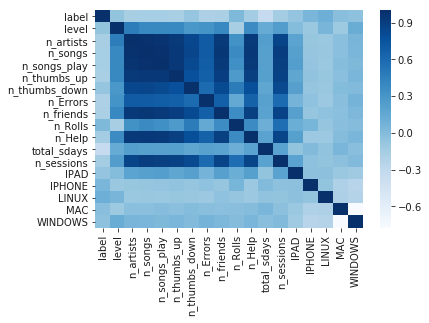

In [220]:
# Let's plot a heatmap with the correlation of the variables
# we can see there are some correlated features, such as number of songs and the number of artist, 
# that are related, the number of songs added to the playlist
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,  cmap="Blues");

In [221]:
# First we have to vectorize our features with a VectorAssembler
# because SparkML requires a vector of features
assembler = VectorAssembler(inputCols=columns_features[1:], outputCol="NumFeatures")
df = assembler.transform(numerical_features)
df

DataFrame[label: int, level: int, n_artists: int, n_songs: double, n_songs_play: double, n_thumbs_up: bigint, n_thumbs_down: bigint, n_Errors: bigint, n_friends: bigint, n_Rolls: bigint, n_Help: bigint, total_sdays: double, n_sessions: bigint, IPAD: bigint, IPHONE: bigint, LINUX: bigint, MAC: bigint, WINDOWS: bigint, NumFeatures: vector]

In [222]:
# The second step is to standardize the features, to avoid that a feature that has higher values,
# dominates the rest of features
# To do that we use the StandardScaler method (scaling the standard deviation) 
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)
df

DataFrame[label: int, level: int, n_artists: int, n_songs: double, n_songs_play: double, n_thumbs_up: bigint, n_thumbs_down: bigint, n_Errors: bigint, n_friends: bigint, n_Rolls: bigint, n_Help: bigint, total_sdays: double, n_sessions: bigint, IPAD: bigint, IPHONE: bigint, LINUX: bigint, MAC: bigint, WINDOWS: bigint, NumFeatures: vector, features: vector]

In [223]:
# We eliminate NumFeatures column as we don't need it anymore
df = df.drop('NumFeatures')

In [224]:
df.take(2)

[Row(label=0, level=0, n_artists=252, n_songs=381.0, n_songs_play=7.0, n_thumbs_up=17, n_thumbs_down=5, n_Errors=0, n_friends=4, n_Rolls=52, n_Help=2, total_sdays=55.64365740740741, n_sessions=7, IPAD=0, IPHONE=1, LINUX=0, MAC=0, WINDOWS=0, features=DenseVector([0.0, 0.4173, 0.2866, 0.214, 0.2596, 0.3823, 0.0, 0.1943, 2.413, 0.2761, 1.4775, 0.4779, 0.0, 4.2764, 0.0, 0.0, 0.0])),
 Row(label=0, level=1, n_artists=339, n_songs=474.0, n_songs_play=8.0, n_thumbs_up=21, n_thumbs_down=6, n_Errors=0, n_friends=4, n_Rolls=7, n_Help=2, total_sdays=70.07462962962963, n_sessions=6, IPAD=0, IPHONE=1, LINUX=0, MAC=0, WINDOWS=0, features=DenseVector([2.0844, 0.5613, 0.3565, 0.2445, 0.3207, 0.4588, 0.0, 0.1943, 0.3248, 0.2761, 1.8606, 0.4096, 0.0, 4.2764, 0.0, 0.0, 0.0]))]

In [225]:
df_final = df.select('label','features')

In [226]:
df_final.take(5)

[Row(label=0, features=DenseVector([0.0, 0.4173, 0.2866, 0.214, 0.2596, 0.3823, 0.0, 0.1943, 2.413, 0.2761, 1.4775, 0.4779, 0.0, 4.2764, 0.0, 0.0, 0.0])),
 Row(label=0, features=DenseVector([2.0844, 0.5613, 0.3565, 0.2445, 0.3207, 0.4588, 0.0, 0.1943, 0.3248, 0.2761, 1.8606, 0.4096, 0.0, 4.2764, 0.0, 0.0, 0.0])),
 Row(label=1, features=SparseVector(17, {1: 0.0132, 2: 0.0083, 8: 0.0464, 10: 1.8936, 11: 0.0683, 15: 2.0533})),
 Row(label=0, features=DenseVector([2.0844, 3.6957, 3.6291, 3.6067, 2.6116, 3.1352, 4.0744, 3.5954, 0.1856, 3.1757, 3.4931, 1.9799, 0.0, 0.0, 0.0, 2.0533, 0.0])),
 Row(label=1, features=DenseVector([2.0844, 2.2932, 1.8533, 1.5894, 1.5272, 1.6058, 0.6791, 1.3604, 0.0, 1.6569, 0.5166, 0.6827, 0.0, 0.0, 0.0, 0.0, 1.9957]))]

In [227]:
df_final.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [228]:
# Split dataset into train and test 70% vs 30%
train, test = df_final.randomSplit([0.7, 0.3], seed = 42)
#train, test, validation = df_final.randomSplit([0.6, 0.2, 0.2], seed = 42)

In [229]:
# Let's check if we have both labels (0/1)
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   37|
|    0|  126|
+-----+-----+



In [230]:
# Let's check if we have both label (0/1)
test.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   15|
|    0|   47|
+-----+-----+



In [231]:
# Let's build a function to calculate the performance of our models
# inspired by https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python
def calculate_performace(results):
    '''
    Function that calculate the performance of a model
    Input:  
            model: model we want to evaluate
    Output: 
            print performance metrics
    '''  
    # Create both evaluators
    evaluatorMulti = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    evaluator = BinaryClassificationEvaluator(labelCol = 'label', rawPredictionCol='prediction', metricName='areaUnderROC')

    # Make predictions
    predictionAndTarget = results.select('label', 'prediction')
    #print ("The Ground Truth is {} and the prediction is ".format(target, prediction))    
    
    # Get metrics
    acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
    f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
    auc = evaluator.evaluate(predictionAndTarget)  
   
    # Prepare a DataFrame with all metrics
    performance = pd.DataFrame(index=['Accuracy', 'F1', 'AUC'], \
                     data={'Performance value': [acc, f1, auc]})
    
    # Return metrics
    return performance       

In [232]:
clf_LR = LogisticRegression(maxIter=10, regParam=0.0)
clf_DT = DecisionTreeClassifier(seed=5)
clf_GBT = GBTClassifier(maxDepth=5, maxIter = 10, seed=42)
clf_RF = RandomForestClassifier(seed=5)
clf_SVM = LinearSVC(maxIter = 10, regParam=0.01)

In [233]:
%%time
############## LOGISTIC REGRESSION ##############
# Train the model
LR_model = clf_LR.fit(train)
# Test the model
prediction_LR = LR_model.transform(test)

# Let's prepare the confusion matrix
# and cast the results to Pandas 
# in order to use sklearn metrics (confussion matrix and classification report)
y_true = prediction_LR.select("label").toPandas()
y_pred = prediction_LR.select("prediction").toPandas()

conf_matrix_LR = confusion_matrix(y_true, y_pred)
clas_rep_LR = classification_report(y_true, y_pred)

print("Logistic Regression:\n")
print(conf_matrix_LR)
print("\n")
print(clas_rep_LR)

Logistic Regression:

[[44  3]
 [11  4]]


             precision    recall  f1-score   support

          0       0.80      0.94      0.86        47
          1       0.57      0.27      0.36        15

avg / total       0.74      0.77      0.74        62

CPU times: user 1.29 s, sys: 311 ms, total: 1.6 s
Wall time: 3min 55s


In [234]:
%%time
############## DECISION TREES ##############
# Train the model
DT_model = clf_DT.fit(train)
# Test the model
prediction_DT = DT_model.transform(test)

# Let's prepare the confusion matrix
# and cast the results to Pandas 
# in order to use sklearn metrics (confussion matrix and classification report)
y_true = prediction_DT.select("label").toPandas()
y_pred = prediction_DT.select("prediction").toPandas()

conf_matrix_DT = confusion_matrix(y_true, y_pred)
clas_rep_DT = classification_report(y_true, y_pred)

print("Decision Trees:\n")
print(conf_matrix_DT)
print("\n")
print(clas_rep_DT)

Decission Trees:

[[39  8]
 [10  5]]


             precision    recall  f1-score   support

          0       0.80      0.83      0.81        47
          1       0.38      0.33      0.36        15

avg / total       0.70      0.71      0.70        62

CPU times: user 1.37 s, sys: 448 ms, total: 1.82 s
Wall time: 4min 51s


In [235]:
%%time
############## GRADIENT BOOSTED TREE ##############
# Train the model
GBT_model = clf_GBT.fit(train)
# Test the model
prediction_GBT = GBT_model.transform(test)

# Let's prepare the confusion matrix
# and cast the results to Pandas 
# in order to use sklearn metrics (confussion matrix and classification report)
y_true = prediction_GBT.select("label").toPandas()
y_pred = prediction_GBT.select("prediction").toPandas()

conf_matrix_GBT = confusion_matrix(y_true, y_pred)
clas_rep_GBT = classification_report(y_true, y_pred)

print("Gradient Boosted Tree:\n")
print(conf_matrix_GBT)
print("\n")
print(clas_rep_GBT)

Gradient Boosted Tree:

[[39  8]
 [ 9  6]]


             precision    recall  f1-score   support

          0       0.81      0.83      0.82        47
          1       0.43      0.40      0.41        15

avg / total       0.72      0.73      0.72        62

CPU times: user 2.55 s, sys: 664 ms, total: 3.21 s
Wall time: 6min 46s


In [236]:
%%time
############## RANDOM FOREST ##############
# Train the model
RF_model = clf_RF.fit(train)
# Test the model
prediction_RF = RF_model.transform(test)

# Let's prepare the confusion matrix
# and cast the results to Pandas 
# in order to use sklearn metrics (confussion matrix and classification report)
y_true = prediction_RF.select("label").toPandas()
y_pred = prediction_RF.select("prediction").toPandas()

conf_matrix_RF = confusion_matrix(y_true, y_pred)
clas_rep_RF = classification_report(y_true, y_pred)

print("Random Forest:\n")
print(conf_matrix_RF)
print("\n")
print(clas_rep_RF)

Random Forest:

[[46  1]
 [12  3]]


             precision    recall  f1-score   support

          0       0.79      0.98      0.88        47
          1       0.75      0.20      0.32        15

avg / total       0.78      0.79      0.74        62

CPU times: user 1.51 s, sys: 422 ms, total: 1.93 s
Wall time: 5min 5s


In [237]:
%%time
############## SUPPORT VECTOR MACHINE ##############
# Train the model
SVM_model = clf_SVM.fit(train)
# Test the model
prediction_SVM = SVM_model.transform(test)

# Let's prepare the confusion matrix
# and cast the results to Pandas 
# in order to use sklearn metrics (confussion matrix and classification report)
y_true = prediction_SVM.select("label").toPandas()
y_pred = prediction_SVM.select("prediction").toPandas()

conf_matrix_SVM = confusion_matrix(y_true, y_pred)
clas_rep_SVM = classification_report(y_true, y_pred)

print("Support Vector Machine:\n")
print(conf_matrix_SVM)
print("\n")
print(clas_rep_SVM)

Support Vector Machine:

[[47  0]
 [15  0]]


             precision    recall  f1-score   support

          0       0.76      1.00      0.86        47
          1       0.00      0.00      0.00        15

avg / total       0.57      0.76      0.65        62

CPU times: user 1.63 s, sys: 492 ms, total: 2.13 s
Wall time: 5min 10s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



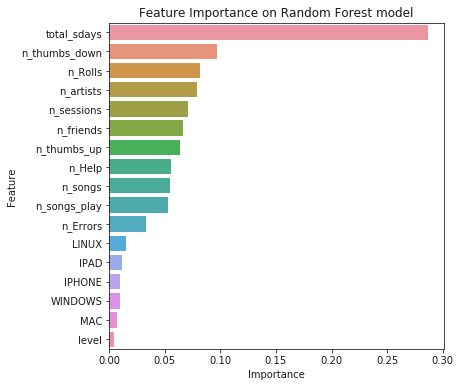

In [242]:
# Random Forest model has the best F1-score
# Let's see the importance feature of this model
# to do that, first we get the indices of the feature importances and convert them to a list
feat_imp_ind   = RF_model.featureImportances.indices.tolist()
# and we get the feature names, from the original final_features except the label (churn)
features_without_label = final_features.columns[1:]
feat_imp_key   = [features_without_label[ind] for ind in feat_imp_ind]
# after that we get the weight, that is, the importance value and convert them to a list
feat_imp_value = RF_model.featureImportances.values.tolist()
# next we get all together in a dataframe, to be able to display it with a nice sns barplot
feat_df        = pd.DataFrame(list(zip(features_without_label,feat_imp_value)),columns=['Feature','Importance']).sort_values('Importance',ascending=False)
# prepare the graphical details
plt.figure(figsize=(6,6))
plt.title("Feature Importance on Random Forest model")
sns.barplot(x='Importance', y='Feature', data=feat_df);
plt.savefig('Feature_Importance_RF.png')

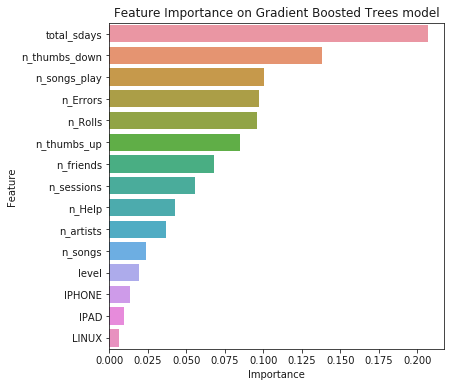

In [243]:
# Gradient Boosted Trees model has the best F1-score
# Let's see the importance feature of this model
# to do that, first we get the indices of the feature importances and convert them to a list
feat_imp_ind   = GBT_model.featureImportances.indices.tolist()
# and we get the feature names, from the original final_features except the label (churn)
features_without_label = final_features.columns[1:]
feat_imp_key   = [features_without_label[ind] for ind in feat_imp_ind]
# after that we get the weight, that is, the importance value and convert them to a list
feat_imp_value = GBT_model.featureImportances.values.tolist()
# next we get all together in a dataframe, to be able to display it with a nice sns barplot
feat_df        = pd.DataFrame(list(zip(features_without_label,feat_imp_value)),columns=['Feature','Importance']).sort_values('Importance',ascending=False)
# prepare the graphical details
plt.figure(figsize=(6,6))
plt.title("Feature Importance on Gradient Boosted Trees model")
sns.barplot(x='Importance', y='Feature', data=feat_df);
plt.savefig('Feature_Importance_GBT.png')

#### Hyperparameter Tuning

In [248]:
%%time
# Now I am going to fine-tune the Decision Tree model
# as it is the one with the highest F1-Score
# Inspiration in https://gist.github.com/colbyford/7758088502211daa90dbc1b51c408762

# Create the initial GBT Model

rf = RandomForestClassifier(featuresCol="features", labelCol="label", maxDepth=2)

# Prepare the parameters to find the best combination
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[15, 20, 25]) \
    .addGrid(rf.maxBins,[2, 4]) \
    .addGrid(rf.maxDepth,[2, 4]) \
    .build()

# Evaluate the model
rfevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create 3-fold CrossValidator
rfcv = CrossValidator(estimator =rf,
                      estimatorParamMaps = rf_param_grid,
                      evaluator = rfevaluator,
                      numFolds = 3)

# Run Cross Validations
rfcvModel = rfcv.fit(train)
print(rfcvModel)

# Use test set here so we can measure the accuracy of our model on new data
rfpredictions = rfcvModel.transform(test)

# Evaluate best model
print('Accuracy:', rfevaluator.evaluate(rfpredictions))

CrossValidatorModel_c7d1d5b93359
Accuracy: 0.7652482269503547
CPU times: user 20.7 s, sys: 6.42 s, total: 27.1 s
Wall time: 43min 59s


In [251]:
best_model = rfcvModel.bestModel
#best_model = best_model.stages[2]
best_model.write().overwrite().save("Best_Random_Forest")

In [252]:
best_model_pred = best_model.transform(test)

In [253]:
y_true_best = best_model_pred.select("label").toPandas()
y_pred_best = best_model_pred.select("prediction").toPandas()

conf_matrix_RF_best = confusion_matrix(y_true_best, y_pred_best)
clas_rep_RF_best = classification_report(y_true_best, y_pred_best)

print("Best Random Forest Trees:\n")
print(conf_matrix_RF_best)
print("\n")
print(clas_rep_RF_best)

Best Random Forest Trees:

[[47  0]
 [15  0]]


             precision    recall  f1-score   support

          0       0.76      1.00      0.86        47
          1       0.00      0.00      0.00        15

avg / total       0.57      0.76      0.65        62



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [ ]:
# The best model after the hyperparameter tuning is not better than the original
# So we will keep the original as the best model

In [ ]:
# In order to execute it on the larger dataset, I will prepare some helper functions
# based on the previous code

In [254]:
def load_data_spark(path_to_dataset):
    '''
    Function that load a dataset
    Input:  
            path_to_dataset: path to the file containing the data
    Output: 
            df: loaded dataset
    '''  
    df = spark.read.json(path_to_dataset)  
    
    return df

In [255]:
def feature_engineerme(df_input):
    '''
    Function that collects the feature to build the ML model
    Input:  
            df_input: dataframe
    Output: 
            df_output: output datadrame with the features
    '''  
    # This dataframe will contain the following features:
    # |-- userId: string (nullable = true)
    # |-- churn: cancellation of the service
    # |-- level: type of subscription + I will convert into number 0/1
    # |-- n_artists: number of artist a user listens to + I will convert into number
    # |-- n_songs:number of songs a user listens to + I will convert into number  
    # |-- n_songs_play:number of songs added to the playlist + I will convert into number   
    # |-- n_thumbs_up: number of thumbs up + I will convert into number
    # |-- n_thumbs_down:  number of thumbs down + I will convert into number 
    # |-- n_Errors: long (nullable = true)
    # |-- n_friends: number of friends + I will convert into number 
    # |-- n_Rolls: number of spots displayed to the user
    # |-- n_Help: number of visits to help page
    # |-- total_sdays: time of the subscription (in days)
    # |-- n_sessions: number of sesions of a user
    # |-- IPAD: the user connects with an IPAD to our Sparkify service
    # |-- IPHONE: the user connects with an IPHONE to our Sparkify service
    # |-- LINUX: the user connects with a Linux device to our Sparkify service
    # |-- MAC: the user connects with a MAC device to our Sparkify service
    # |-- WINDOWS: the user connects with a WINDOWS to our Sparkify service


    churn = df_input.groupby('userId').max("churn").withColumnRenamed("max(churn)", "churn")
    df_churn = churn.withColumn('churn', churn.churn.cast('int'))
    df_churn.count()
        
    level = df_input.select(['userId', 'level','ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level']).replace(['free', 'paid'], ['0', '1'], 'level')
    ## Let's change level into a numerical,binary field (0/1)
    #level = df_valid.select(['userId', 'level']).dropDuplicates(['userId']).replace(['free', 'paid'], ['0', '1'], 'level')
    df_level = level.withColumn('level', level.level.cast('int'))
    df_level.count()
    
    # Let's calculate the number of artists a user listens to 
    n_artists = df_input.filter(df_valid.page=="NextSong").select(['userId', 'artist']).dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'n_artists')
    df_n_artists= n_artists.withColumn('n_artists', n_artists.n_artists.cast('int'))
    df_n_artists.count()
    
    n_songs = df_input.select('userId','song').groupBy('userId').count().withColumnRenamed('count', 'n_songs')
    df_n_songs= n_songs.withColumn('n_songs', n_songs.n_songs.cast('double'))
    df_n_songs.count()
    
    n_songs_play = df_input.select('userId', 'page').where(df_valid.page =='Add to Playlist').groupBy('userId').agg({'page':'count'}).withColumnRenamed('count(page)','n_songs_play')
    df_n_songs_play = n_songs_play.withColumn('n_songs_play', n_songs_play.n_songs_play.cast('double'))
    df_n_songs_play.count()
        
    n_thumbs_up = df_input.select('userId','page').where(df_valid.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'n_thumbs_up')
    df_n_thumbs_up= n_thumbs_up.withColumn('n_thumbs_up', n_thumbs_up.n_thumbs_up.cast('bigint'))
    df_n_thumbs_up.count()
    
    n_thumbs_down = df_input.select('userId','page').where(df_valid.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'n_thumbs_down')
    df_n_thumbs_down= n_thumbs_down.withColumn('n_thumbs_down', n_thumbs_down.n_thumbs_down.cast('bigint'))
    df_n_thumbs_down.count()
    
    n_Errors = df_input.select('userId','page').where(df_valid.page == 'Error').groupBy('userId').count().withColumnRenamed('count', 'n_Errors')
    df_n_Errors = n_Errors.withColumn('n_Errors', n_Errors.n_Errors.cast('bigint'))
    df_n_Errors.count()
    
    n_friends = df_input.select('userId','page').where(df_valid.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'n_friends')
    df_n_friends= n_friends.withColumn('n_friends', n_friends.n_friends.cast('bigint'))
    df_n_friends.count()
    
    n_Rolls = df_input.select('userId','page').where(df_valid.page == 'Roll Advert').groupBy('userId').count().withColumnRenamed('count', 'n_Rolls')
    df_n_Rolls = n_Rolls.withColumn('n_Rolls', n_Rolls.n_Rolls.cast('bigint'))
    df_n_Rolls.count()
    
    # Let's calculate the number of Help a user visits
    n_Help = df_input.select('userId','page').where(df_valid.page == 'Help').groupBy('userId').count().withColumnRenamed('count', 'n_Help')
    df_n_Help = n_Help.withColumn('n_Help', n_Help.n_Help.cast('bigint'))
    df_n_Help.count()
    
    # Let's calculate the subscription days a user stays in the service
    subscription_days = df_input.select('userId','subscription_days').groupBy('userId').agg({'subscription_days':'max'}).withColumnRenamed('max(subscription_days)','total_sdays')
    df_subscription_days = subscription_days.withColumn('total_sdays', subscription_days.total_sdays.cast('double'))
    df_subscription_days.count()

    n_sessions = df_input.select('userId','sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count','n_sessions')
    df_n_sessions = n_sessions.withColumn('n_sessions', n_sessions.n_sessions.cast('bigint'))
    df_n_sessions.count()
    
    # Let's take the OS the user connects to the Sparkify session and make one hot encoding with the pivot option
    df_os = df_valid.select('userId','OS').dropDuplicates().groupby('userId').pivot('OS').agg(count('OS')).fillna(0)   
    
    df_output = df_churn.join(df_level,'userId','outer')\
     .join(df_n_artists,'userId','outer') \
     .join(df_n_songs,'userId','outer') \
     .join(df_n_songs_play,'userId','outer')\
     .join(df_n_thumbs_up,'userId','outer') \
     .join(df_n_thumbs_down,'userId','outer') \
     .join(df_n_Errors,'userId','outer') \
     .join(df_n_friends,'userId','outer') \
     .join(df_n_Rolls,'userId','outer') \
     .join(df_n_Help,'userId','outer') \
     .join(df_subscription_days,'userId','outer') \
     .join(df_n_sessions,'userId','outer') \
     .join(df_os,'userId','outer')
    

    return df_output

In [256]:
# Test if the feature function works fine
df_final_feat = feature_engineerme(df_valid)

In [257]:
# Yes! it works fine!
df_final_feat

DataFrame[userId: string, churn: int, level: int, n_artists: int, n_songs: double, n_songs_play: double, n_thumbs_up: bigint, n_thumbs_down: bigint, n_Errors: bigint, n_friends: bigint, n_Rolls: bigint, n_Help: bigint, total_sdays: double, n_sessions: bigint, IPAD: bigint, IPHONE: bigint, LINUX: bigint, MAC: bigint, WINDOWS: bigint]

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.